# Eye Blink Detection using Facial Landmarks

To build our blink detector, we’ll be computing a metric called the **eye aspect ratio (EAR)**, introduced by _Soukupová and Čech in their 2016 paper, Real-Time Eye Blink Detection Using Facial Landmarks._


Unlike traditional image processing methods for computing blinks which typically involve some combination of:

1. Eye localization.
2. Thresholding to find the whites of the eyes.
3. Determining if the “white” region of the eyes disappears for a period of time (indicating a blink).

The eye aspect ratio is instead a much more elegant solution that involves a very simple calculation based on the ratio of distances between facial landmarks of the eyes.

This method for eye blink detection is fast, efficient, and easy to implement.



## Understanding the “eye aspect ratio” (EAR)

We can apply facial landmarks detection to localize important regions of the face, including eyes, eyebrows, nose, ears, and mouth.


Each eye is represented by _6 (x,y)-coordinates_, strarting at the left-corner of the eye, and then working clockwise.

<img src="https://www.pyimagesearch.com/wp-content/uploads/2017/04/blink_detection_6_landmarks.jpg">

Based on this image, we should take away on key point:

__There is a relation between the width and the height of these coordinates.__

$$EAR = \frac{\left \| p_2 - p_6 \right \| + \left \| p_3 - p_5 \right \|}{2\left \| p_1 - p_4 \right \|} $$

Where p1, …, p6 are 2D facial landmark locations.

The __numerator of this equation computes the distance between the vertical eye landmarks__ while the __denominator computes the distance between the horizontal eye landmarks,__ weighting the denominator appropriately since there is only one set of horizontal points but two sets of vertical points. 


Why is this equation so interesting?

Well, the eye aspect ratio is approximately constant while the eye is open, but will rapidly fall to zero when a blink is taking place.

Using this simple equation, we can avoid image processing techniques and simply rely on the ratio of eye landmark distances to determine if a person is blinking.

To make this more clear, consider the following figure from Soukupová and Čech:

<img src="https://www.pyimagesearch.com/wp-content/uploads/2017/04/blink_detection_plot.jpg">

On the top-left we have an eye that is fully open — the eye aspect ratio here would be large(r) and relatively constant over time.

However, once the person blinks (top-right) the eye aspect ratio decreases dramatically, approaching zero.

The bottom figure plots a graph of the eye aspect ratio over time for a video clip. As we can see, the eye aspect ratio is constant, then rapidly drops close to zero, then increases again, indicating a single blink has taken place.

## Detecting blinks with facial landmarks and OpenCV

In [45]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
path_video = "blink8.mp4"
# This is the path to the facial landmark perdictor 
path_shape_predictor = "shape_predictor_68_face_landmarks.dat"

Define `eye_aspect_ratio` function:

In [47]:
def eye_aspect_ratio(eye):
    # compute the euclidean distance between two sets of 
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    
    # compute the euclidean distance between horizontal 
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])
    
    # compute th eye aspect ratio
    ear = (A + B)/ (2 * C)
    
    # return the eye aspect ratio
    return ear

This function accepts a single required parameter, the (x, y)-coordinates of the facial landmarks for a given `eye`.

We now need to set two important constants that you may need to tune for your own implementation, along with initialize two other important variables, so be sure to pay attention to this explantation:

In [48]:
# define two constants, one for the EAR to indicate 
# blink and the second constant for the number of consecutive 
# frames the eye must be below the threshold to register as a 'blink'

EYE_AR_THRESH = 0.2
EYE_AR_CONSEC_FRAMES = 3

# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

If the eye aspect ratio falls below a certain threshold and then rises above the threshold, then we’ll register a “blink” — the `EYE_AR_THRESH`  is this threshold value. We default it to a value of `0.3`  as this is what has worked best for my applications, but you may need to tune it for your own application.

We then have an important constant, `EYE_AR_CONSEC_FRAME`  — this value is set to 3  to indicate that three successive frames with an eye aspect ratio less than `EYE_AR_THRESH`  must happen in order for a blink to be registered.

__Depending on the frame processing throughput rate of your pipeline, you may need to raise or lower this number for your own implementation.__

Initialize two counters. `COUNTER`  is the _total number of successive frames that have an eye aspect ratio less than_ `EYE_AR_THRESH`,  while `TOTAL`  is the _total number of blinks that have taken place while the script has been running._

Now that our imports, command line arguments, and constants have been taken care of, we can initialize dlib’s face detector and facial landmark detector:

In [49]:
# initialize dlib's face detector (HOG-based) and then create 
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_shape_predictor)

[INFO] loading facial landmark predictor...


Get the facial landmarks of the left and right eye

<img src = "https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup-768x619.jpg">

In [50]:
# grab the indexes of the facial landmarks for the left and the right
# eye, respectively

(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS['left_eye'] 
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_68_IDXS['right_eye']

Start the video stream

In [59]:
print("[INFO] starting video")
vs = FileVideoStream(path_video).start()

fileStream =True

time.sleep(1.0) # sleep to let video buffer a bit

[INFO] starting video


Let's move on the main loop

In [60]:
# import this to display images like a video in notebook
from IPython.display import display , Image, clear_output 

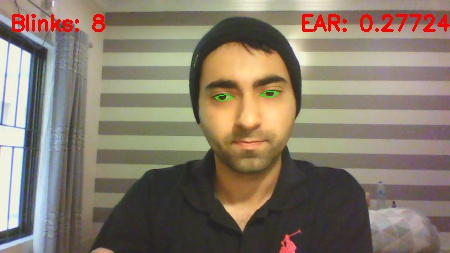

In [61]:
# loop over frames from the video stream
while True:
    # if this is a file video stream, then we need to check if there are
    # any more frames left in the buffer to process
    if fileStream and not vs.more():
        break
        
    # grab the frame from the threaded videofile stream, resize it and
    # convert it to grayscale
    frame = vs.read()
    if frame is None:
        break
    
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
    # detect the faces in the grayscale frame
    rects = detector(gray, 0)
    
    # loop over faces
    for rect in rects:
        # determine the landmarks and convert them to numpy
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        
        # extract left and right eye coordinates
        leftEye = shape[lStart: lEnd]
        rightEye = shape[rStart: rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        
        # average the eye aspect ratio together for both eyes
        ear = (leftEAR +  rightEAR)/ 2
        
        # compute the convex hull for the left and right eye, then
        # visualize each of the eyes
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        # check to see if the eye aspect ratio is below our defined
        # blink thresh, and if so, incrementing counter
        if ear < EYE_AR_THRESH:
            COUNTER += 1
            
        # otherwise, the EAR is not below thresh
        else:
            # if the eyes were closed for a sufficent number of frames
            # then increment the total number of blinks
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
            
            # reset frame counter
            COUNTER = 0
            
        # finall write on the frame the number of blinks along with
        # the computed eye aspect ratio for the frame
        cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "EAR: {}".format(ear), (300, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # for jupyter first we need to save the image then dsplay it 
    # for a video like effect
    cv2.imwrite('pic.jpg', frame) # first we save it
    display(Image("pic.jpg"))

    clear_output(wait=True)

# Reset total 
TOTAL=0

__Following the suggestion of Soukupová and Čech, we average the two eye aspect ratios together to obtain a better blink estimate (making the assumption that a person blinks both eyes at the same time, of course).__

**Line 41** makes a check to see if the eye aspect ratio is below our blink threshold — if it is, we increment the number of consecutive frames that indicate a blink is taking place (**Line 42**).

Otherwise, **Line 44** handles the case where the eye aspect ratio is not below the blink threshold.

In this case, we make another check on **Line 48* to see if a sufficient number of consecutive frames contained an eye blink ratio below our pre-defined threshold.

If the check passes, we increment the TOTAL  number of blinks (**Line 49**).

We then reset the number of consecutive blinks COUNTER  (**Line 52**).

To make our blink detector more robust to these challenges, Soukupová and Čech recommend:

- Computing the eye aspect ratio for the N-th frame, along with the eye aspect ratios for N – 6 and N + 6 frames, then concatenating these eye aspect ratios to form a 13 dimensional feature vector.
- Training a Support Vector Machine (SVM) on these feature vectors.

Soukupová and Čech report that the combination of the temporal-based feature vector and SVM classifier helps reduce false-positive blink detections and improves the overall accuracy of the blink detector.


## Using dlib's cnn based face detector 

In [ ]:
import numpy as np
import dlib
import matplotlib.pyplot as plt
import cv2
from imutils import face_utils
import imutils
%matplotlib inline

In [ ]:
dlib.__version__

In [ ]:
path_image = "myimg4.jpg"

# path_image = "the_expendables.jpg"
cnn_model_path = "..\\DNN_MODELS\\mmod_human_face_detector.dat"

# # This is the path to the facial landmark perdictor 
path_shape_predictor = "shape_predictor_68_face_landmarks.dat"

cnn_face_detector = dlib.cnn_face_detection_model_v1(cnn_model_path)
predictor = dlib.shape_predictor(path_shape_predictor)

#### NOTE: dlib.load_rgb_image() does not take into account the EXIF orientation metadata so, some images will be in the wrong orientaion!

**so either read EXIF data and correct orientation on offending image or use _OpenCV's imread()_ method as it takes into account the orientaion metadata.**

In [ ]:
# Does not take into account the the orientation metadata
img = dlib.load_rgb_image(path_image)
print(img.shape)
plt.imshow(img)
plt.show()

So, using the OpenCV imread, instead

In [ ]:
img = cv2.imread(path_image)
img = img[...,::-1] # BGR to RGB
plt.imshow(img)
plt.show()

In [ ]:
# resize image to a manageble size to apss through CNN

og_h, og_w = img.shape[:2] # resize image height width 
img_copy = imutils.resize(img, width=500)

h_ratio = og_h / img_copy.shape[0]
w_ratio = og_w / img_copy.shape[1]

print(img_copy.shape)

plt.imshow(img_copy)
plt.show()

In [ ]:
# The 1 in the second argument indicates that we should upsample the image
# 1 time.  This will make everything bigger and allow us to detect more
# faces.
detections = cnn_face_detector(img_copy, 1)

This detector returns a mmod_rectangles object. This object contains a list of __mmod_rectangle__ objects.
These objects can be accessed by simply iterating over the mmod_rectangles object
The mmod_rectangle object has two member variables: 
1. a dlib.rectangle object, and
2. a confidence score.

In [ ]:
print("Number of faces detected: {}".format(len(detections)))

In [ ]:
bounded_faces = img.copy()

for i, d in enumerate(detections):
    print("Detection {}:\n \tLeft: {} \n\tTop: {} \n\tRight: {} \n\tBottom: {} \n\tConfidence: {}".format(
            i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
    # draw bounding box
    x, y, h, w = face_utils.rect_to_bb(d.rect)
    x, y, h, w = int(x*w_ratio), int(y*h_ratio), int(w*w_ratio), int(h*h_ratio)
    print("{}, {}, {}, {}".format(x,y,h,w))
    cv2.rectangle(bounded_faces, pt1=(x,y), pt2=(h+x,w+y), color=(255,0,0), thickness=3 )
    cv2.putText(bounded_faces, "{:.2f}".format(d.confidence*100), (x+10, y-10) ,cv2.FONT_HERSHEY_SIMPLEX, 3, color=(0,255,0), thickness=6)    

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.imshow(bounded_faces)
plt.show()

In [ ]:
bounded_faces = img.copy()

for i, d in enumerate(detections):
    print("Detection {}:\n \tLeft: {} \n\tTop: {} \n\tRight: {} \n\tBottom: {} \n\tConfidence: {}".format(
            i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
    
    # get landmarks on bounded face
    
    print(img_copy.shape)
    shape = predictor(img_copy, d.rect)
    shape = face_utils.shape_to_np(shape)
    
    # draw bounding box
    x, y, h, w = face_utils.rect_to_bb(d.rect)
    x, y, h, w = int(x*w_ratio), int(y*h_ratio), int(w*w_ratio), int(h*h_ratio)
    print("{}, {}, {}, {}".format(x,y,h,w))
    cv2.rectangle(bounded_faces, pt1=(x,y), pt2=(h+x,w+y), color=(255,0,0), thickness=3 )
    cv2.putText(bounded_faces, "{:.2f}".format(d.confidence*100), (x+10, y-10) ,
                cv2.FONT_HERSHEY_SIMPLEX, 3, color=(0,255,0), thickness=6)
    
    # iterate over all the landmarks and draw them
    for l in shape:
        cv2.circle(bounded_faces, center=(int(l[0]*h_ratio), int(l[1]*w_ratio)) ,
                   radius=7, color=(255, 0, 0), thickness=-1)


In [ ]:

fig = plt.figure(figsize=(16,16))
plt.imshow(bounded_faces)
plt.show()